In [1]:
# --- ÉTAPE 1 : IMPORTATIONS ET CHARGEMENT DES DONNÉES ---

# --- 1.1 Importation des bibliothèques nécessaires ---
import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Journaux pour suivre l'exécution
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

logger.info("✅ Bibliothèques importées.")

# --- 1.2 Chargement du dataset CIC-IDS2017 ---
dataset_path = 'C:/Users/MTechno/OneDrive/Desktop/PFE/PFE/MachineLearningCVE'
csv_files = glob.glob(os.path.join(dataset_path, "*.csv"))

if not csv_files:
    logger.error("❌ Aucun fichier CSV trouvé dans le dossier spécifié.")
else:
    # Vérification des colonnes pour cohérence
    columns_set = set()
    for f in csv_files:
        temp_df = pd.read_csv(f, nrows=5)
        columns_set.add(tuple(temp_df.columns))
    
    if len(columns_set) > 1:
        logger.error("❌ Les fichiers CSV ont des colonnes incohérentes.")
    else:
        df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)
        logger.info(f"✅ Dataset chargé. Il contient {df.shape[0]} lignes et {df.shape[1]} colonnes.")


2025-06-15 20:59:35,613 - INFO - ✅ Bibliothèques importées.
2025-06-15 21:00:10,315 - INFO - ✅ Dataset chargé. Il contient 2830743 lignes et 79 colonnes.


In [2]:
# --- ÉTAPE 2 : EXPLORATION ET NETTOYAGE ---

logger.info(f"Dimensions avant nettoyage : {df.shape}")
df.columns = df.columns.str.strip()  # Nettoyer les noms de colonnes
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Remplacer les valeurs infinies par NaN

# Remplir les valeurs manquantes
missing_columns = df.columns[df.isna().any()].tolist()
if missing_columns:
    for col in missing_columns:
        df[col].fillna(df[col].median(), inplace=True)
    logger.info("✅ Valeurs manquantes remplacées par la médiane.")

# Suppression des doublons et colonnes inutiles
df.drop_duplicates(inplace=True)
cols_to_drop = [col for col in df.columns if df[col].nunique() == 1]
if cols_to_drop:
    df.drop(columns=cols_to_drop, inplace=True)
    logger.info(f"✅ Colonnes redondantes supprimées : {cols_to_drop}")

logger.info(f"✅ Nettoyage terminé. Dimensions finales : {df.shape}")


2025-06-15 21:00:10,341 - INFO - Dimensions avant nettoyage : (2830743, 79)
2025-06-15 21:00:13,641 - INFO - ✅ Valeurs manquantes remplacées par la médiane.
2025-06-15 21:00:51,205 - INFO - ✅ Colonnes redondantes supprimées : ['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
2025-06-15 21:00:51,206 - INFO - ✅ Nettoyage terminé. Dimensions finales : (2522362, 71)


In [3]:
# --- ÉTAPE 3 : REGROUPEMENT DES LABELS ET ENCODAGE ---

df['Label'] = df['Label'].str.strip()
df['Label'] = df['Label'].str.replace('�', '', regex=False)

# Dictionnaire de regroupement des labels
attack_mapping = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'PortScan': 'PortScan',
    'Bot': 'Bot',
    'DoS GoldenEye': 'DoS', 'DoS Hulk': 'DoS', 'DoS Slowhttptest': 'DoS', 'DoS slowloris': 'DoS',
    'FTP-Patator': 'Brute Force', 'SSH-Patator': 'Brute Force',
    'Web Attack – Brute Force': 'Web Attack', 
    'Web Attack – XSS': 'Web Attack', 
    'Web Attack – Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration/Exploit', 
    'Heartbleed': 'Infiltration/Exploit'
}
df['Label'] = df['Label'].map(attack_mapping)

# Gérer les labels non mappés
unmapped_labels = df['Label'][df['Label'].isna()].unique()
if len(unmapped_labels) > 0:
    logger.warning(f"❌ Labels non mappés détectés : {unmapped_labels}")
    df = df.dropna(subset=['Label'])  # Exclure les lignes non mappées
    logger.info(f"✅ Lignes avec labels non mappés exclues. Dimensions finales : {df.shape}")

logger.info("Nouvelle distribution des labels après regroupement :")
logger.info(df['Label'].value_counts())

X = df.drop(columns=['Label'])
y_temp = df['Label']
le = LabelEncoder()
y = le.fit_transform(y_temp)
logger.info("✅ Labels regroupés et encodés.")

2025-06-15 21:00:54,174 - WARNING - ❌ Labels non mappés détectés : [nan]
2025-06-15 21:00:55,306 - INFO - ✅ Lignes avec labels non mappés exclues. Dimensions finales : (2520219, 71)
2025-06-15 21:00:55,309 - INFO - Nouvelle distribution des labels après regroupement :
2025-06-15 21:00:55,633 - INFO - Label
BENIGN                  2096484
DoS                      193748
DDoS                     128016
PortScan                  90819
Brute Force                9152
Bot                        1953
Infiltration/Exploit         47
Name: count, dtype: int64
2025-06-15 21:00:57,039 - INFO - ✅ Labels regroupés et encodés.


In [4]:
# --- ÉTAPE 4 : SÉPARATION DES DONNÉES ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
logger.info(f"Taille de l'entraînement : {X_train.shape[0]} échantillons.")
logger.info(f"Taille du test : {X_test.shape[0]} échantillons.")


2025-06-15 21:01:02,584 - INFO - Taille de l'entraînement : 1764153 échantillons.
2025-06-15 21:01:02,592 - INFO - Taille du test : 756066 échantillons.


2025-06-15 21:01:07,414 - INFO - 1. Données normalisées.
2025-06-15 21:03:10,700 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-15 21:03:10,757 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-15 21:03:11,195 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-15 21:03:11,210 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


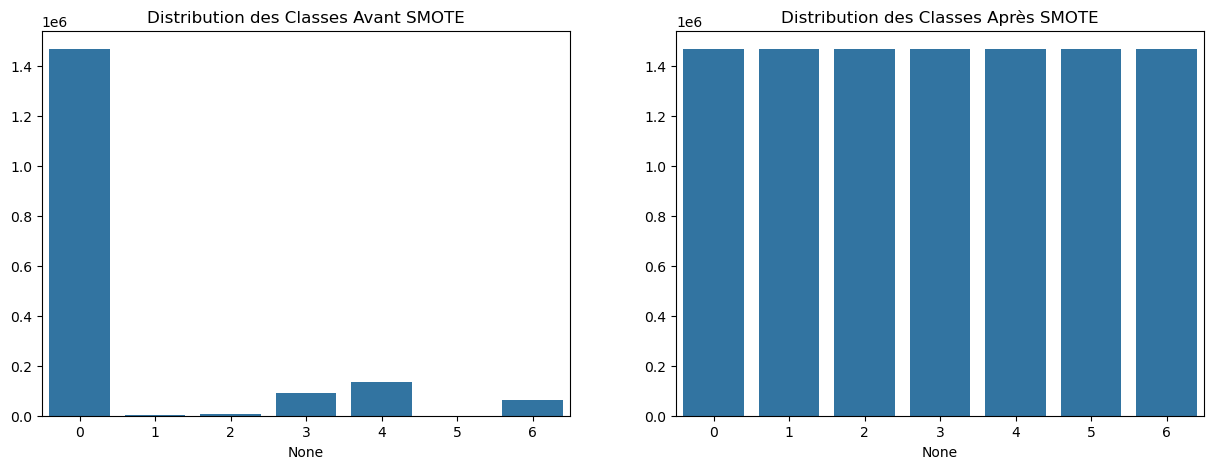

2025-06-15 21:03:11,917 - INFO - ✅ Rééchantillonnage SMOTE appliqué.
2025-06-15 21:03:28,448 - INFO - ✅ Réduction de dimensionnalité avec PCA appliquée. Nombre de caractéristiques réduit à 4.


In [5]:
# --- ÉTAPE 5 : PRÉTRAITEMENT AVANCÉ ET RÉDUCTION DE DIMENSIONNALITÉ ---

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
logger.info("1. Données normalisées.")

# Appliquer SMOTE uniquement sur les données d'entraînement
smote = SMOTE(random_state=42, n_jobs=-1)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Visualisation de la distribution des classes avant et après SMOTE
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x=pd.Series(y_train).value_counts().index, 
            y=pd.Series(y_train).value_counts().values, ax=axes[0])
axes[0].set_title("Distribution des Classes Avant SMOTE")
sns.barplot(x=pd.Series(y_train_smote).value_counts().index, 
            y=pd.Series(y_train_smote).value_counts().values, ax=axes[1])
axes[1].set_title("Distribution des Classes Après SMOTE")
plt.show()

logger.info("✅ Rééchantillonnage SMOTE appliqué.")

# Réduction de dimensionnalité avec PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test_scaled)
logger.info(f"✅ Réduction de dimensionnalité avec PCA appliquée. Nombre de caractéristiques réduit à {X_train_pca.shape[1]}.")


2025-06-15 21:22:28,104 - INFO - ✅ Modèle entraîné.
2025-06-15 21:22:31,216 - INFO - 
--- Évaluation du modèle sur l'ensemble de test ---
2025-06-15 21:23:22,971 - INFO -                       precision    recall  f1-score   support

              BENIGN     0.9992    0.9950    0.9971    628945
                 Bot     0.2147    0.9113    0.3475       586
         Brute Force     0.9498    0.9931    0.9710      2746
                DDoS     0.9978    0.9988    0.9983     38405
                 DoS     0.9895    0.9949    0.9922     58124
Infiltration/Exploit     0.1000    0.5714    0.1702        14
            PortScan     0.9878    0.9956    0.9917     27246

            accuracy                         0.9951    756066
           macro avg     0.7484    0.9229    0.7811    756066
        weighted avg     0.9972    0.9951    0.9959    756066



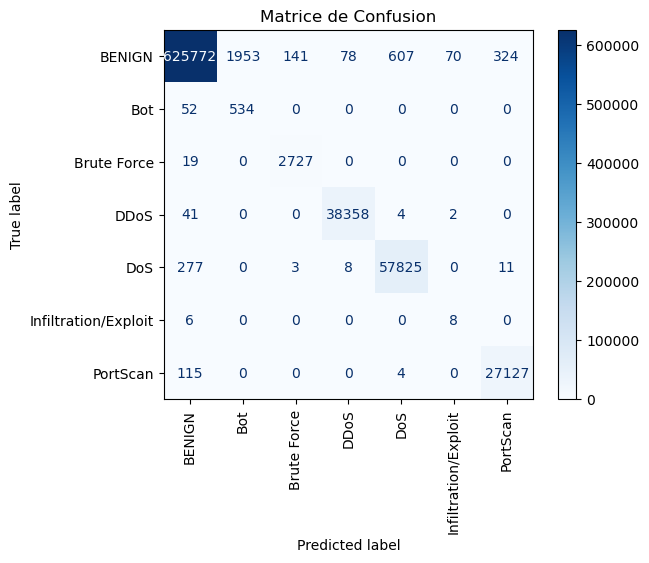

In [6]:
# --- ÉTAPE 6 : MODÉLISATION ET ÉVALUATION ---

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_pca, y_train_smote)
logger.info("✅ Modèle entraîné.")

# Évaluation sur l'ensemble de test
y_pred = model.predict(X_test_pca)
y_pred_decoded = le.inverse_transform(y_pred)
y_test_decoded = le.inverse_transform(y_test)

logger.info("\n--- Évaluation du modèle sur l'ensemble de test ---")
logger.info(classification_report(y_test_decoded, y_pred_decoded, digits=4))

# Matrice de confusion
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.title("Matrice de Confusion")
plt.show()

In [7]:
# --- ÉTAPE 7 : SAUVEGARDE DES ARTEFACTS ---

import joblib
import zipfile

artefacts = {'Label Encoder': le, 'Scaler': scaler, 'PCA': pca, 'Model': model}
zip_filename = 'pipeline_artefacts.zip'
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for name, obj in artefacts.items():
        filename = f"{name.replace(' ', '_').lower()}.joblib"
        joblib.dump(obj, filename)
        zipf.write(filename)
        os.remove(filename)

logger.info(f"✅ Artefacts sauvegardés dans '{zip_filename}'.")

2025-06-15 21:23:30,167 - INFO - ✅ Artefacts sauvegardés dans 'pipeline_artefacts.zip'.
